In [1]:
import pandas as pd
import folium
from geopy import distance
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import geopandas as gpd
import libpysal
from shapely.geometry import Point, Polygon
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
from contextily import add_basemap
import networkx as nx
import numpy as np
import logging
import requests_cache
import requests
import json

In [2]:
df = pd.read_csv(r"C:\Users\marco\Downloads\Electric_Vehicle_Charging_Stations_in_New_York.csv")

In [3]:
colonne_irrilevanti = ['Fuel Type Code', 'Intersection Directions', 'Station Phone', 'Status Code',
                       'Owner Type Code', 'Federal Agency ID', 'Federal Agency Name', 'Cards Accepted',
                       'EV Network Web', 'ZIP', 'Groups With Access Code', 'Expected Date', 'Access Days Time',
                       'Geocode Status', 'Updated At', 'Plus4', 'Date Last Confirmed', "EV Other Info", "Open Date"]

# Eliminazione delle colonne irrilevanti
df.drop(colonne_irrilevanti, axis=1, inplace=True)

In [4]:
df.head()

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types
0,ShopRite Plaza,2333 Nott St E,Niskayuna,NY,NaN,2.0,NaN,Non-Networked,42.816614,-73.889657,50854,J1772
1,GMC Copley Parking - Tesla,2000 Broadway,New York,NY,NaN,3.0,NaN,Tesla,40.775496,-73.981552,115044,TESLA
2,WHITE PLAINS EVSE1,1 Maple Ave,White Plains,NY,NaN,2.0,NaN,ChargePoint Network,41.028410,-73.759380,197206,J1772
3,3500 Dekalb Ave,3500 Dekalb Ave,Bronx,NY,NaN,2.0,NaN,FLO,40.882337,-73.880265,201636,J1772
4,134 N 4th St,134 N 4th St,Brooklyn,NY,NaN,4.0,NaN,FLO,40.716441,-73.960043,202931,J1772


In [5]:
città_rilevanti = ['New York',"Bronx","Brooklyn","Queens","Staten Island",
         "Manhattan","Borough Park","Washington Heights","New York City",
        "Astoria","Jamaica","JAMAICA","Jackson Heights",]
esclusione = ["Geneva on the Lake Resort", "ABELENORTHSIDE STATION 1","Buy Low Flooring / Queen of Harts Pizza"]
Network = ["Tesla","LIVINGSTON","EV Connect"]

In [8]:
df = df.query("City not in @città_rilevanti")

In [9]:
occurrences = df['EV_Network'].value_counts()
print(occurrences)

ChargePoint Network    1454
Non-Networked           275
Tesla                   243
EV Connect              216
LIVINGSTON              207
Blink Network            41
Electrify America        35
AMPUP                    23
SHELL_RECHARGE           23
eVgo Network             21
Volta                    19
SemaCharge Network       16
FLO                       7
RIVIAN_WAYPOINTS          4
SWTCH                     3
OpConnect                 2
FLASH                     1
Name: EV_Network, dtype: int64


In [10]:
# NYC_df = NYC_df.query("City not in @esclusione")

In [11]:
df = df.query("EV_Network in @Network")

I 4 maggiori Network di ricarica appartengono a Tesla, Livingstone e EV Connect, e non sono compresi in nessun network specifico. Con questi 4 otteniamo circa il 42% della rete. Per semplicità terremo solo le stazioni che fanno parte dei 3 network principali.

Vengono eliminate le colonne che non presentano dati utili all'analisi o che presentano dei NaN in ogni osservazione.

In [12]:
df.index.names = ['Index']
df = df.fillna(value=0)
df.shape

(666, 12)

Il dataset presenta 666 osservazioni, solo relative allo stato di New York. 

In [13]:
df =df.reset_index(drop=True)
# NYC_df = NYC_df.drop(labels=[368], axis=0)

In [14]:
df

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types
0,Agawam Park,88 Jobs Ln,Southampton,NY,0.0,4.0,0.0,LIVINGSTON,40.882950,-72.392170,223289,J1772
1,College Park Hall Lot,450 Nott Street,Schenectady,NY,0.0,4.0,0.0,EV Connect,42.820404,-73.935231,154918,J1772
2,Russell Sage Jr. College,140 New Scotland Ave,Albany,NY,0.0,4.0,0.0,LIVINGSTON,42.651430,-73.782380,223220,J1772
3,Greymoor Way - Building 13A,2604 Pipers Ct,Baldwinsville,NY,0.0,2.0,0.0,LIVINGSTON,43.181630,-76.299510,223127,J1772
4,iPark 43-25 Hunter Street - Tesla,43-25 Hunter St,Long Island City,NY,0.0,8.0,0.0,Tesla,40.747653,-73.942313,114969,TESLA
...,...,...,...,...,...,...,...,...,...,...,...,...
661,Yonkers City Hall Parking Garage,40 South Broadway,Yonkers,NY,0.0,5.0,0.0,EV Connect,40.932086,-73.897953,94870,J1772
662,Scarsdale Golf Club,1 Club Way,Hartsdale,NY,0.0,4.0,0.0,LIVINGSTON,41.011020,-73.798900,223245,J1772
663,SPOT cowork Rochester - Tesla,21 Goodway Dr,Rochester,NY,0.0,4.0,0.0,Tesla,43.091974,-77.580604,154441,TESLA
664,Veterans Memorial Park,185 Main St,Mount Morris,NY,0.0,4.0,0.0,EV Connect,42.718388,-77.869315,168430,J1772


In [15]:
# NYC_df["Next Latitude"],NYC_df["Next Longitude"] = "",""

In [16]:
# for i in range(0, (NYC_df.shape[0]-1)):
#          NYC_df["Next Latitude"][i] = NYC_df["Latitude"][i+1]
#          NYC_df["Next Longitude"][i] = NYC_df["Longitude"][i+1]

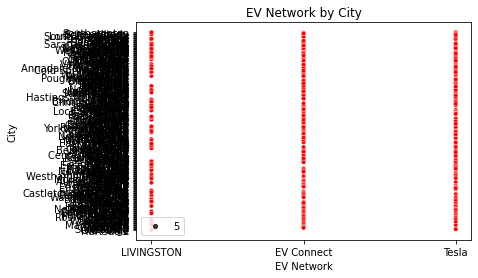

In [17]:
sns.scatterplot(x='EV_Network', y='City', data=df, size=5, color='red')
plt.title("EV Network by City")
plt.xlabel("EV Network")
plt.ylabel("City")
plt.show()

Plot della mappa

In [14]:
location = df[["Latitude", "Longitude", "Station Name","EV_Network","ID"]]

# Calculate the center of the map based on the mean of Latitude and Longitude values
mean_latitude = location['Latitude'].mean()
mean_longitude = location['Longitude'].mean()
map = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=6, control_scale=True)

location.apply(lambda x: folium.Marker([x["Latitude"], x["Longitude"]], popup=x["EV_Network"]).add_to(map), axis=1)
map


Calcolo distanza e tempo di guida da una colonnina alla successiva

In [15]:
df["Distance"],df["Duration"]="",""

Calcolo della distanza tramite Open Street Map

In [16]:
API_key = '96dd7cb32a8d43a1b8c78d219b21d381'
url = 'http://router.project-osrm.org/route/v1/driving/'

In [17]:
def getDistances(row):
    o1 = str(row['Longitude']) +',' + str(row['Latitude'])
    o2 = str(row['Next Longitude']) + ',' + str(row['Next Latitude']) 
    x = o1 + ';' + o2
    
    response = requests.get(url+x)
    data = json.loads(response.content)
    
    if response.status_code == 200:
        return data['routes'][0]['distance']/1000 #in km
    else:
        return 0

In [18]:
def getDuration(row):
    o1 = str(row['Longitude']) +',' + str(row['Latitude'])
    o2 = str(row['Next Longitude']) + ',' + str(row['Next Latitude']) 
    x = o1 + ';' + o2
    
    response = requests.get(url+x)
    data = json.loads(response.content)
    
    if response.status_code == 200:
        return data['routes'][0]['duration']/60 #in min
    else:
        return 0

In questo modo abbiamo ottenuto la distanza (in miglia) tra una colonnina e la successiva

In [19]:
# Network = ["Tesla","Non-Networked","LIVINGSTON","EV Connect"]
tesla_df = df[df['EV_Network'] =="Tesla"]
evc_df = df[df['EV_Network'] =="EV Connect"]
l_df = df[df['EV_Network'] =="LIVINGSTON"]

In [20]:
tesla_df = tesla_df.sort_values(by=["City",'Latitude', 'Longitude'])
evc_df = evc_df.sort_values(by=["City",'Latitude', 'Longitude'])
l_df = l_df.sort_values(by=["City",'Latitude', 'Longitude'])

In [21]:
tesla_df["Next Latitude"] = tesla_df["Latitude"].shift(-1)
tesla_df["Next Longitude"] = tesla_df["Longitude"].shift(-1)

In [22]:
evc_df["Next Latitude"] = evc_df["Latitude"].shift(-1)
evc_df["Next Longitude"] = evc_df["Longitude"].shift(-1)

In [23]:
l_df["Next Latitude"] = l_df["Latitude"].shift(-1)
l_df["Next Longitude"] = l_df["Longitude"].shift(-1)

Divido il dataset in 4 (uno per ogni network) in modo da poter confrontare i pattern di posizionamento.

In [45]:
tesla_df =tesla_df.reset_index(drop=True)
evc_df =evc_df.reset_index(drop=True)
l_df =l_df.reset_index(drop=True)

In [25]:
tesla_df["Distance"]  = tesla_df.apply(getDistances, axis = 1)
tesla_df["Duration"]  = tesla_df.apply(getDuration, axis = 1)
evc_df["Distance"]  = evc_df.apply(getDistances, axis = 1)
evc_df["Duration"]  = evc_df.apply(getDuration, axis = 1)
l_df["Distance"]  = l_df.apply(getDistances, axis = 1)
l_df["Duration"]  = l_df.apply(getDuration, axis = 1)

In [75]:
tesla_df
# quantiles = tesla_df["Distance"].quantile([0.25, 0.75])
# media = tesla_df["Distance"].mean()
# quantiles_d= tesla_df["Duration"].quantile([0.25, 0.75])
# media_d = tesla_df["Duration"].mean()
# print("\nQuantili a 0.25 e 0.75:")
# print(quantiles)
# print(media)
# print("\nQuantili a 0.25 e 0.75:")
# print(quantiles_d)
# print(media_d)
tesla_df = tesla_df.loc[tesla_df['Distance'] > 500]
tesla_df = tesla_df.loc[tesla_df['Duration'] > 150]

In [76]:
evc_df
# quantiles = evc_df["Distance"].quantile([0.25, 0.75])
# media = evc_df["Distance"].mean()
# quantiles_d= evc_df["Duration"].quantile([0.25, 0.75])
# media_d = evc_df["Duration"].mean()
# print("\nQuantili a 0.25 e 0.75:")
# print(quantiles)
# print(media)
# print("\nQuantili a 0.25 e 0.75:")
# print(quantiles_d)
# print(media_d)

evc_df = evc_df.loc[evc_df['Distance'] > 500]
evc_df = evc_df.loc[evc_df['Duration'] > 150]

In [77]:
l_df
# quantiles = l_df["Distance"].quantile([0.25, 0.75])
# media = l_df["Distance"].mean()
# quantiles_d= l_df["Duration"].quantile([0.25, 0.75])
# media_d = l_df["Duration"].mean()
# print("\nQuantili a 0.25 e 0.75:")
# print(quantiles)
# print(media)
# print("\nQuantili a 0.25 e 0.75:")
# print(quantiles_d)
# print(media_d)

l_df = l_df.loc[l_df['Distance'] > 500]
l_df = l_df.loc[l_df['Duration'] > 150]

Plot dei grafi divisi per ogni Network

In [78]:
tesla_df =tesla_df.reset_index(drop=True)
evc_df =evc_df.reset_index(drop=True)
l_df =l_df.reset_index(drop=True)

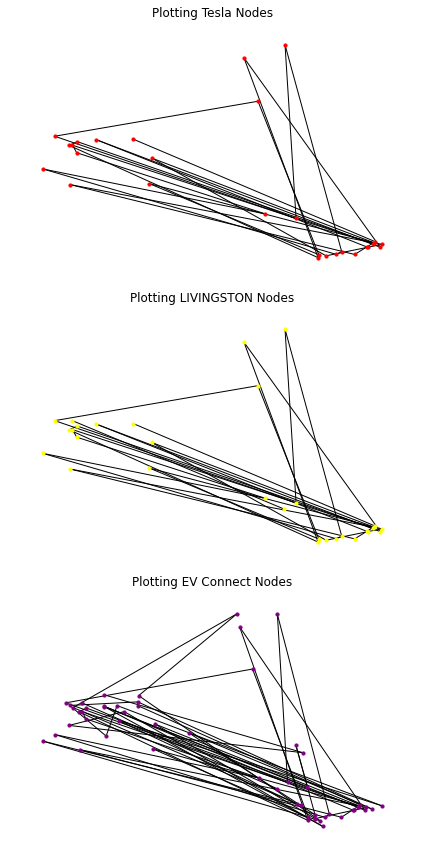

In [79]:
G = nx.Graph()

fig, axs = plt.subplots(3, 1, figsize=(6, 12))
axs = axs.ravel()

data = [(tesla_df, "red", "Plotting Tesla Nodes"),            
        (l_df, "yellow", "Plotting LIVINGSTON Nodes"),            
        (evc_df, "purple", "Plotting EV Connect Nodes")]

for idx, (df, color, title) in enumerate(data):
    for i in range(df.shape[0]-1):
        G.add_node(df["ID"][i], pos=(df["Longitude"][i], df["Latitude"][i]))
        # add edge between nodes
        if i > 0:
            G.add_edge(df["ID"][i-1], df["ID"][i])
    nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=False, node_size=10, node_color=color, ax=axs[idx])
    axs[idx].set_title(title)

plt.tight_layout()
plt.savefig("./Graph_State.png", dpi=300)
plt.show()


Tutti e 3 i grafi disegnati presetano dei tratti molto simili, quasi a voler indicare un pattern di poszionamento. 